# Volatile Bandits Demo

In [19]:
import numpy as np
from numpy.random import choice
import pandas as pd
from random import random, sample
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

class AB(object):
    def __init__(self, n_arms, 
                 default_count=1.0, 
                 default_value=1.0,
                stop_after=30):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value
        self.counter = 0
        self.stop_after = stop_after

    def choose_arm(self):
        self.counter = (self.counter + 1) % self.n
        counts = sorted([(self.counts[arm], arm) for arm in range(self.n)])
        if counts[0][0] < self.stop_after:
            return counts[0][1]
        else:# self.counter > self.n*self.stop_after:
            return np.argmax(self.values)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        self.counter = 0
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return list(zip(self.values, np.zeros(self.n)))

class Greedy(object):
    def __init__(self, n_arms, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value

    def choose_arm(self):
        return np.argmax(self.values)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))
    
class EpsilonGreedy(object):
    def __init__(self, n_arms, epsilon=0.1, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.epsilon = epsilon
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value

    def choose_arm(self):
        if np.random.random() > self.epsilon:
            return np.argmax(self.values)
        else:
            return np.random.randint(self.n)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))

class EpsilonDecreasing(object):
    def __init__(self, n_arms, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.epsilon = (2*self.n)
        self.epsilon /= (self.counts.sum() + 2*self.n)
        self.default_count = default_count
        self.default_value = default_value

    def choose_arm(self):
        self.epsilon = (2*self.n) 
        self.epsilon /= (self.counts.sum() + 2*self.n)
        if np.random.random() > self.epsilon:
            return np.argmax(self.values)
        else:
            return np.random.randint(self.n)

    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value
        
    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        return zip(self.values, np.zeros(self.n))
    
class UCB(object):
    def __init__(self, n_arms=2, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value
        self.delta = 0.015

    def choose_arm(self):
        ucbs = [0.]*self.n
        T = self.counts.sum()
        for i in range(self.n):
            p = self.values[i]
            n = self.counts[i]
            ucb = p + self.delta*sqrt(2*T/n)
            ucbs[i] = ucb
        return np.argmax(ucbs)
    
    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value

    def update(self, arm, reward):
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / float(n)) * value 
        new_value += (1 / float(n)) * reward
        self.values[arm] = new_value
    
    def get_arm_data(self):
        ci = np.zeros(self.n)
        T = self.counts.sum()
        for i in range(self.n):
            p = self.values[i]
            n = self.counts[i]
            ci[i] = self.delta*sqrt(2*T/float(n))
        return zip(self.values, ci)
    
class Bayesian(object):
    def __init__(self, n_arms=2, 
                 default_count=1.0, 
                 default_value=1.0):
        self.counts = np.zeros(n_arms)+default_count
        self.values = np.zeros(n_arms)+default_value
        self.n = n_arms
        self.default_count = default_count
        self.default_value = default_value
        self.delta = 0.015

    def choose_arm(self):
        rvs = np.zeros(self.n)
        for i in range(self.n):
            rvs[i] = np.random.beta(self.default_value+self.values[i],
                               self.default_count+self.counts[i]-self.values[i])
        return np.argmax(rvs)
    
    def reset_arm(self, arm):
        self.counts[arm] = self.default_count
        self.values[arm] = self.default_value

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += reward
    
    def get_arm_data(self):
        expected_values = np.zeros(self.n)
        for i in range(self.n):
            a = self.default_value + self.values[i]
            b = self.default_count + self.counts[i] - self.values[i]
            expected_values[i] = a/(a+b)
        return zip(expected_values, np.zeros(self.n))
    
class Bayesian2(object):
    def __init__(self, n_arms=2, 
                 default_alpha=1.0, 
                 default_beta=1.0,
                 C=20):
        self.n = n_arms
        self.C = C
        self.default_alpha = default_alpha
        self.default_beta = default_beta
        self.arms = {}
        for i in range(self.n):
            self.arms[i] = {}
            self.arms[i]['a'] = self.default_alpha
            self.arms[i]['b'] = self.default_beta

    def choose_arms(self, k_arms=1):
        res = []
        for i in range(self.n):
            res.append((np.random.beta(self.arms[i]['a'], self.arms[i]['b']), i))
        return [e[1] for e in sorted(res, reverse=True)[:k_arms]]

    def add_arm(self):
        self.n += 1
        arm_id = self.n
        self.arms[arm_id] = {}
        self.arms[arm_id]['a'] = self.default_alpha
        self.arms[arm_id]['b'] = self.default_beta
        return arm_id

    def reset_arm(self, arm_id):
        self.arms[arm_id]['a'] = self.default_alpha
        self.arms[arm_id]['b'] = self.default_beta

    def update(self, arm_id, reward):
        C = self.C
        if reward == 0:
            if self.arms[arm_id]['a'] + self.arms[arm_id]['b'] > C:
                self.arms[arm_id]['b'] += 1.0
            else:
                self.arms[arm_id]['a'] *= C/float(C+1)
                self.arms[arm_id]['b'] = (self.arms[arm_id]['b']+1)*C/float(C+1)
            
        elif reward == 1:
            if self.arms[arm_id]['a'] + self.arms[arm_id]['b'] <= C:
                self.arms[arm_id]['a'] += 1.0
            else:
                self.arms[arm_id]['a'] = (self.arms[arm_id]['a']+1)*C/float(C+1)
                self.arms[arm_id]['b'] *= C/float(C+1)

    def get_arm_data(self):
        expected_values = np.zeros(self.n)
        for i in range(self.n):
            a = self.arms[i]['a']
            b = self.arms[i]['b']
            expected_values[i] = a/(a+b)
        return list(zip(expected_values, np.zeros(self.n)))


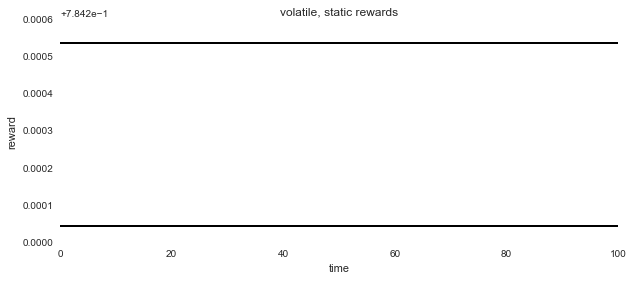

In [20]:
# create volatile static data
def volatile_step(vec, p = 0.1):
    new_vec = np.copy(vec)
    news = np.zeros(vec.shape[0])
    for i in range(len(new_vec)):
        if random() > p: # stay alive
            news[i] = 0
        else: # replace
            new_vec[i] = random()
            news[i] = 1
    return new_vec, news

# takes 2 2d arrays, returns list of lists
def transform_volatile_for_plotting(actual, news):
    assert actual.shape == news.shape
    res = []
    rows, cols = actual.shape[0], actual.shape[1]
    for j in range(cols):
        inds = np.nonzero(news[:,j])[0].tolist()
        if inds[-1] != rows-1:
            inds.append(rows-1) # insure >= 2 1's
        bounds = zip(inds[:-1], inds[1:])
        for b in bounds:
            xs = range(b[0], b[1]+1)
            ys = actual[b[0]:b[1], j].tolist()
            ys.append(actual[b[1]-1,j])
            assert len(xs) == len(ys)
            res.append((xs, ys))
    return res

# function for plotting static data

# data like [[(x,y), (x,y)],[(x,y),...]]
def plot_volatile_static_data(data, ax=None, 
                            title='volatile, static rewards'):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,4))
    ax.set_title(title)
    ax.set_xlabel('time')
    ax.set_ylabel('reward')
    
    for i, d in enumerate(data):
        xs, ys = d
        ax.plot(xs, ys, linewidth=2, c='k')
    ax.set_axis_bgcolor('white')
    ax.grid('off')
    #sb.set_style("white")
    
def gen_volatile_static_data(k = 10, T = 300, p = 0.01):
    rewards = np.random.rand(k)
    steps = [rewards]
    news = [[1]*rewards.shape[0]]
    for i in range(T):
        r, nw = volatile_step(steps[-1], p)
        steps.append(r)
        news.append(nw)
            
    return np.array(steps), np.array(news)

k, T = 2, 100
data, news = gen_volatile_static_data(k, T)
#res = transform_volatile_static_for_plotting(data, news)
res = transform_volatile_for_plotting(data, news)
plot_volatile_static_data(res)

## plotting bandit beliefs

(300, 3, 2)
(300, 3, 2)


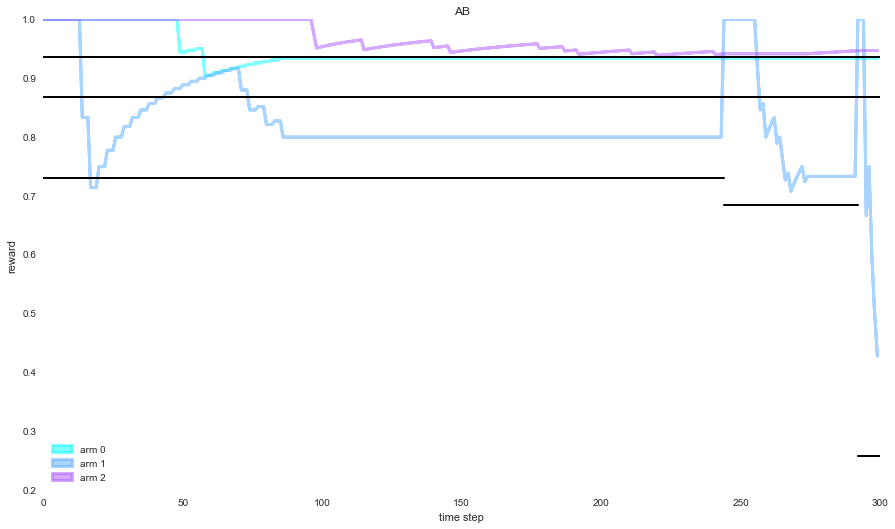

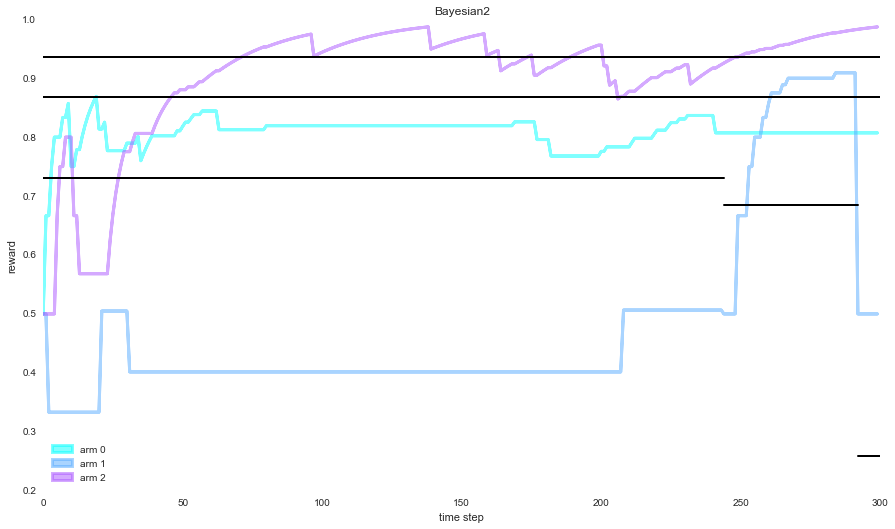

In [21]:
def test_volatile(k = 2, T = 10, 
                actual = None,
                news = None,
                bandit = None):
    rewards = np.zeros(T)
    arm_data = []
    regret = np.zeros(T)
    arms_selected = np.zeros((T, k))
    choices = range(k)
    for t in range(T):
        # reset arms that need it
        ns = news[t]
        #print 'ns', ns
        inds = np.nonzero(ns)[0]
        #print 'inds', inds
        if type(bandit) == type(Bayesian2()):
            arm = bandit.choose_arms()[0]
            #print 'bayesian arm choosen:', arm
            for i in inds:
                #print i
                if i != arm:
                    bandit.reset_arm(i)
        else:
            arm = bandit.choose_arm()
            for i in inds:
                bandit.reset_arm(i)

        actual_best = np.max(actual[t])
        reward = 0.0
        if actual[t][arm] > np.random.random():
            reward = 1.0
        rewards[t] = reward
        regret[t] = (t+1)*actual_best - rewards.sum() # cumulative regret
        arm_data.append(bandit.get_arm_data())
        bandit.update(arm, reward)
    arm_data = np.array(arm_data)
    return rewards, arm_data, regret

def plot_arm_data_plus_actual(arm_data, actual, news, 
                              fs=(15,8.45), 
                              colormap = plt.cm.cool,
                              fig_title='title'):
    fig, ax = plt.subplots(figsize=fs)
    res = transform_volatile_for_plotting(actual, news)
    plot_volatile_static_data(res, ax)
    
    ax.set_title(fig_title); ax.grid('off')
    ax.set_xlabel('time step'); ax.set_ylabel('reward')
    print(arm_data.shape)
    k = arm_data.shape[1]
    #print 'arm_data.shape[1]', k
    for i in range(k):
        color = colormap(i/float(k))
        xs = range(len(arm_data))
        ys = np.array([e[i][0] for e in arm_data])
        #print i
        #print ys
        err = np.array([(e[i][1]) for e in arm_data])
        ax.fill_between(xs, ys+err, ys-err, color=color, alpha=0.5, 
                        label='arm '+str(i), linewidth=3)
#        ax.errorbar(xs, ys, yerr=err, c=color, 
#                    alpha=0.25, label=str(i)+' bandit',
#                    linewidth=4)
    #ax.set_ylim([-0.1, 1.1])
    ax.legend(loc='best')
    ax.set_axis_bgcolor('white')
    
def demo_bandits():
    k, T = 3, 300
    actual, news = gen_volatile_static_data(k, T, 0.005)
    bandits = [
        AB(k), 
        #Greedy(k),
        #EpsilonGreedy(k, 0.1),
        #EpsilonDecreasing(k),
        #UCB(n_arms=k),
        Bayesian2(k, C=25)
        ]
    for b in bandits:
        rewards, arm_data, regret = test_volatile(k, T, 
                                                  actual, 
                                                  news, b)
        #print(arm_data)
        bandit_name = b.__class__.__name__
        plot_arm_data_plus_actual(arm_data, actual, news, 
                                  fig_title=bandit_name)
        
demo_bandits()

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


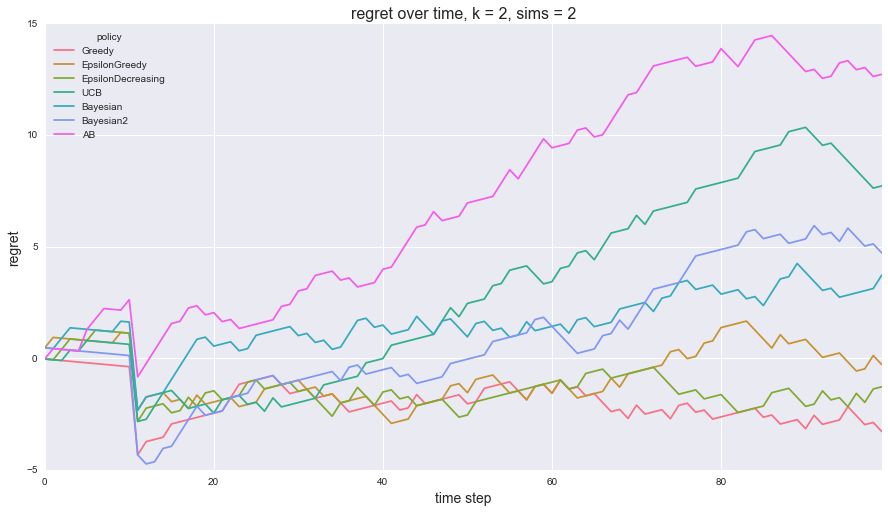

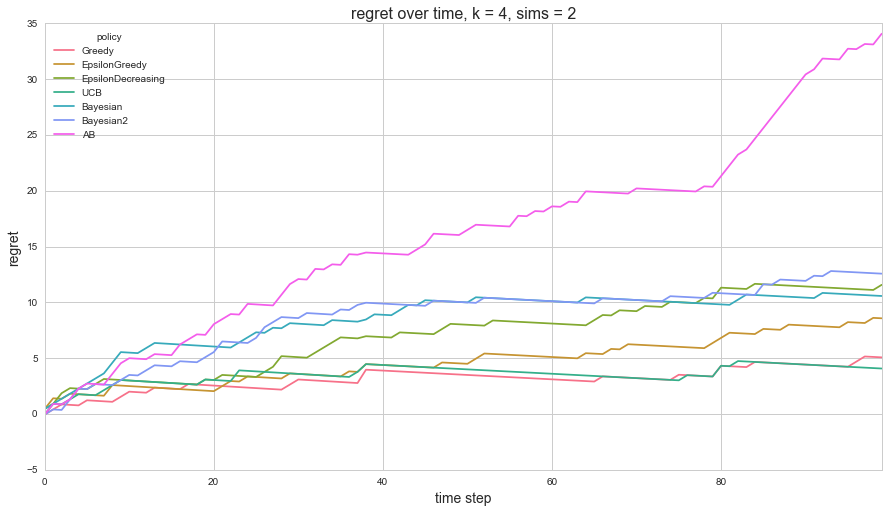

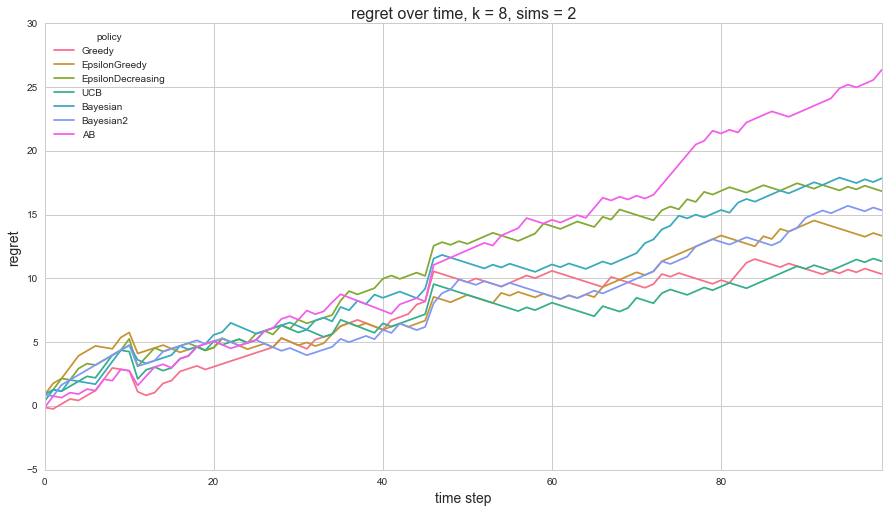

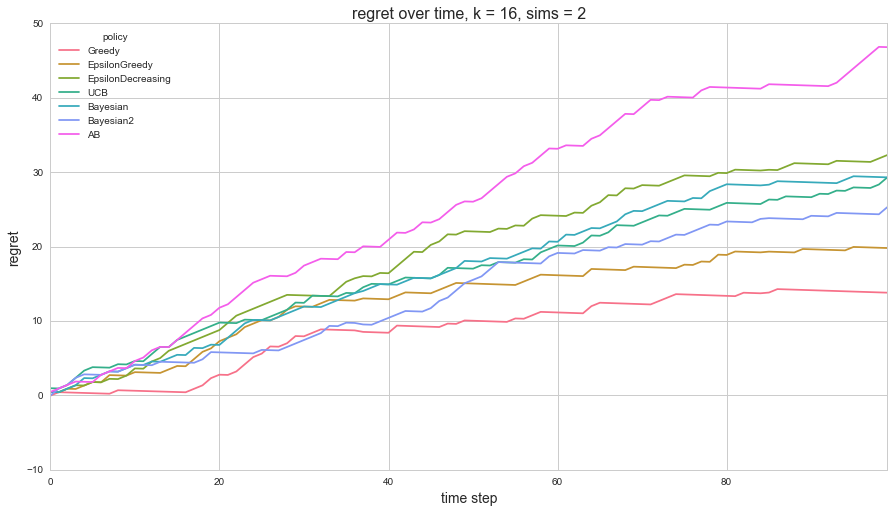

In [22]:
def do_sims(bandits, n_sims=10, k=3, T=100, data_gen=gen_volatile_static_data, 
            params=None):
    #if data_gen == gen_static_beta:
    #    a, b = params['a'], params['b']
    actual, news = gen_volatile_static_data(k, T)
    ts = pd.Series(range(T))
    df_final = None
    for sim in range(n_sims):
        for i, bandit in enumerate(bandits):
            bandit = bandit(k)
            rewards, arm_data, regret = test_volatile(k, T, actual, news, bandit)
            rewards = rewards.tolist()
            df = pd.DataFrame(ts, columns=['time'])
            df['policy'] = [bandit.__class__.__name__]*T
            df['regret'] = regret
            df['sim'] = pd.Series([sim]*T)
            if df_final is None:
                df_final = df
            else:
                df_final = pd.concat([df_final, df], ignore_index=True)
    fig, ax = plt.subplots(figsize=(15,8), dpi=200)
    ax.set_title('regret over time, k = '+str(k)+', sims = '+str(n_sims), 
                 fontsize=16)
    sb.set_palette('colorblind')
    sb.set_style("whitegrid")
    sb.tsplot(df_final, time='time', unit='sim', value='regret', 
              condition='policy', 
              ci=1, ax=ax)
    ax.set_xlabel('time step', fontsize=14)
    ax.set_ylabel('regret', fontsize=14)
    
bandits = [Greedy, EpsilonGreedy, EpsilonDecreasing, UCB, Bayesian, Bayesian2,
           AB]
params = {'a': 2, 'b': 10}
for k in [2, 4, 8, 16]:
    #do_sims(bandits, n_sims=10, k=k, T=100, data_gen=gen_static_uniform)
    do_sims(bandits, 2, k, 100)#, gen_volatile_static_data, params)


   0  1  2  3  4  5  6  7  8  9
0  1  0  1  0  0  0  0  0  0  0
1  1  1  1  1  1  1  1  1  1  1
2  0  1  1  1  1  1  0  0  1  1
3  0  0  0  0  0  1  0  0  1  0
4  0  0  0  0  0  0  1  0  0  0
5  0  0  0  0  0  0  0  1  0  1
6  0  0  0  0  0  0  0  0  1  0


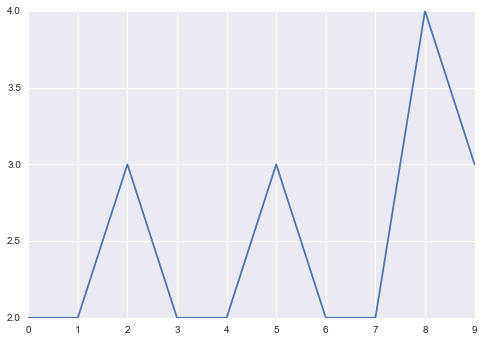

In [4]:
data = [
    [1,1,0,0,0,0,0],
    [0,1,1,0,0,0,0],
    [1,1,1,0,0,0,0],
    [0,1,1,0,0,0,0],
    [0,1,1,0,0,0,0],
    [0,1,1,1,0,0,0],
    [0,1,0,0,1,0,0],
    [0,1,0,0,0,1,0],
    [0,1,1,1,0,0,1],
    [0,1,1,0,0,1,0],
]
#data = 
df = pd.DataFrame(data).T
print(df)
df.sum().plot()

In [7]:
from sklearn import datasets

//anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [8]:
iris = datasets.load_iris()
digits = datasets.load_digits()
iris.target.shape

(150,)

In [9]:
from sklearn import svm
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(digits.data[:-1], digits.target[:-1])

//anaconda/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [10]:
digits.data[:-1].shape, digits.target[:-1].shape

((1796, 64), (1796,))

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [12]:
clf = KNeighborsClassifier(3)
clf.fit(iris.data, iris.target)

//anaconda/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=3, p=2, weights='uniform')

In [13]:
accuracy_score(clf.predict(iris.data), iris.target)

0.95999999999999996

In [26]:
Y = list(iris.target)
#print(list(Y))
X = iris.data
res_final = []
bandit = Bayesian2(0, C=10)
bandit_k = Bayesian2(0, C=10)
for n in range(10,30):
    js = set(range(X.shape[0]))
    clfs = []
    xs, ys = [], []
    res = []
    for i in range(iris.data.shape[0]):
        j = sample(js, 1)[0]
        js.remove(j)
        #print j
        if i < n:
            guess = sample(Y, 1)[0]
            res.append(guess==Y[j])
        else:
            preds = []
            n_cls = bandit.choose_arms()
            for cl in clfs:
                preds.append(cl.predict(X[j]))
            pred = sample(preds, 1)[0]
            res.append(pred==Y[j])
        xs.append(X[j])
        ys.append(Y[j])
        if len(xs) == n:
            clf = KNeighborsClassifier(3)
            clf.fit(xs, ys)
            clfs.append(clf)
            arm_id = bandit.add_arm()
            bandit_k.add_arm()
            xs, ys = [], []
    d = pd.Series(res).astype(float)
    print(n, d.mean())
    res_final.append((n, d.mean()))
df = pd.DataFrame(res_final, columns=['n', 'res'])#.astype(int)
df.plot(x='n')

KeyError: 0